# Create a ball model in the dataset given the ball size
Goal: create the contact mask and heightmap of a calibration ball in Taxim so that we have ground truth to compare with <br>
ToDo: Following the 'textured.mat' file in shape_mapping_root_path/models/obj, create a similar file for calibration ball

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os, sys
import os.path as osp
from mpl_toolkits.mplot3d import Axes3D

In [2]:
shape_mapping_root_path = osp.normpath(osp.join(os.path.abspath(''), '..', '..', '..'))
print(f"shape_mapping_root_path: {shape_mapping_root_path}")

shape_mapping_root_path: /home/ruihan/Documents/16741_proj/Shape_Mapping_Tactile-main


## Step 0. Check the convetion of the existing textured.mat file

In [3]:
sample_mat_path = osp.join(shape_mapping_root_path, 'models', '006_mustard_bottle', 'textured.mat')
sample_mat = sio.loadmat(sample_mat_path)
print(f"keys of sample_mat: {sample_mat.keys()}")
print(f"num_vertices {sample_mat['vertices'].shape[0]}, num_normals {sample_mat['normals'].shape[0]}, num_faces {sample_mat['faces'].shape[0]}")

keys of sample_mat: dict_keys(['__header__', '__version__', '__globals__', 'None', 'vertices', 'normals', 'faces', '__function_workspace__'])
num_vertices 262146, num_normals 262146, num_faces 524288


## Step 1. Create mesh for calibration ball

In [4]:
def create_ball_mesh(radius, num_vertices):
    # Generate a list of spherical coordinates for the vertices
    theta = np.linspace(0, 2 * np.pi, num_vertices)
    phi = np.linspace(0, np.pi, num_vertices)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    # Create a list of vertices
    vertices = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

    # Calculate normals for the vertices (normals are the same as vertex positions for a sphere) but need to be unit length
    normals = vertices / np.linalg.norm(vertices, axis=1)[:, None]

    # Generate faces
    faces = []
    for i in range(num_vertices - 1):
        for j in range(num_vertices - 1):
            v0 = i * num_vertices + j
            v1 = v0 + 1
            v2 = (i + 1) * num_vertices + j
            v3 = v2 + 1
            faces.extend([(v0, v1, v2), (v2, v1, v3)])

    # Create the dictionary
    ball_mesh = {
        'vertices': vertices,
        'normals': normals,
        'faces': np.array(faces)
    }

    return ball_mesh

In [5]:
def render_mesh(vertices):
    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract the x, y, and z coordinates of the vertices
    x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]

    # Plot the mesh
    ax.plot_trisurf(x, y, z, triangles=faces, cmap='viridis')
    # ax.scatter(x, y, z, c='r', marker='o')


    # Set axis labels (optional)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Show the plot
    plt.show()

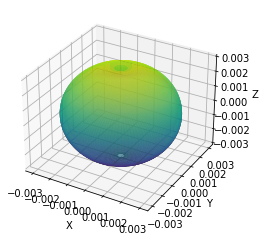

In [6]:
# Example usage:
radius = 0.003 # unit: meter
num_vertices = 512  # You can tune this parameter to control the mesh detail
ball_mesh_dict = create_ball_mesh(radius, num_vertices)

# You can access the vertices, normals, and faces in the dictionary as needed.
vertices = ball_mesh_dict['vertices']
normals = ball_mesh_dict['normals']
faces = ball_mesh_dict['faces']

# Now you can use this data to create or render the ball mesh as needed.
render_mesh(vertices)

# save this ball mesh to models folder
ball_mesh_path = osp.join(shape_mapping_root_path, 'models', 'calib_ball', 'textured.mat')
if not osp.exists(osp.dirname(ball_mesh_path)):
    os.makedirs(osp.dirname(ball_mesh_path))
sio.savemat(ball_mesh_path, ball_mesh_dict)

## Step 2. Create .ply file for calibration ball

In [7]:
## Method 1. Using "write" so that it can be read by "readlines"

# Create the PLY file in ASCII format

# Specify the file path where you want to save the .ply file
ball_ply_path = osp.join(shape_mapping_root_path, 'data', 'ball', 'ball.ply')

with open(ball_ply_path, 'w') as ply_file:
    # Write the PLY header
    ply_file.write("ply\n")
    ply_file.write("format ascii 1.0\n")
    ply_file.write("comment VCGLIB generated \n")
    ply_file.write(f"element vertex {str(len(vertices))}\n") # must convert to str type to be read properly
    ply_file.write("property float x\n")
    ply_file.write("property float y\n")
    ply_file.write("property float z\n")
    ply_file.write(f"element face 0\n")
    ply_file.write("property list uchar int vertex_indices\n")
    ply_file.write("end_header\n")
    
    # Write vertex data
    for i in range(len(vertices)):
        vertex = vertices[i]
        # normal = normals[i]
        ply_file.write(f"{vertex[0]:.7f} {vertex[1]:.7f} {vertex[2]:.7f} \n")

    # # Write face data
    # for face in faces:
    #     ply_file.write(f"3 {face[0]} {face[1]} {face[2]}\n")

In [8]:
## Method 2. This method can create a .ply file, but cannot be read by "readlines" in gelsightSimPybullet.py

# import numpy as np
# from plyfile import PlyData, PlyElement

# print(f"vertices shape {vertices.shape}, normals shape {normals.shape}, faces shape {faces.shape}") # [1024, 3], [1024, 3], [1922, 3]
# # Create a PlyElement for vertices
# vertex_properties = [
#     ('x', 'f4'),
#     ('y', 'f4'),
#     ('z', 'f4'),
#     ('nx', 'f4'),
#     ('ny', 'f4'),
#     ('nz', 'f4'),
# ]
# vertex_data = np.empty(len(vertices), dtype=vertex_properties)
# for i in range(0, 3):
#     vertex_data[vertex_properties[i][0]] = vertices[:, i]
# for i in range(0, 3):
#     vertex_data[vertex_properties[i+3][0]] = normals[:, i]
# vertex_element = PlyElement.describe(vertex_data, 'vertex') 

# # Create a PlyElement for faces
# face_data = np.zeros((len(faces),), dtype=[('vertex_indices', 'i4', (3,))])
# assert faces.shape[1] == 3 # Triangle
# for i, face in enumerate(faces):
#     face_data[i] = face.tolist()
# face_element = PlyElement.describe(face_data, 'face')

# # Create a PlyData object and write it to a .ply file
# ply_data = PlyData([vertex_element, face_element])

# # Specify the file path where you want to save the .ply file
# ball_ply_path = osp.join(shape_mapping_root_path, 'data', 'ball', 'ball.ply')

# # Write the PlyData to the .ply file
# ply_data.write(ball_ply_path)
